In [1]:
from transformers import set_seed, BertTokenizer, BertModel
from tqdm import tqdm
import argparse, torch
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
from matplotlib import colors
import torch.nn.functional as f
import numpy as np
import matplotlib
font = {'family' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
set_seed(2022)

/mnt/lustre/lujinghui1/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
parser = argparse.ArgumentParser(description='search for best template according to dev set')
parser.add_argument('--max_len', default=512, type=int, help="max sequence length")
parser.add_argument('--batch_size', default=2, type=int, help="batch size")
parser.add_argument('--model', default='../models/my_bert/', type=str, help="pretrained model")
parser.add_argument('--tokenizer', default='../models/my_bert/', type=str, help="tokenizer")
parser.add_argument('--task', default='weibo', type=str, help="task name")
parser.add_argument('--datasets', default='../datasets_ppl_score/', type=str, help="dataset dir")
parser.add_argument('--template', default='很好。', type=str, help="template")
parser.add_argument('--input_data', default='../datasets/', type=str, help="input data dir")
args = parser.parse_args(args=[])

device = 'cuda:0'

In [5]:
tokenizer = BertTokenizer.from_pretrained(f'{args.tokenizer}')
pretrained_model = BertModel.from_pretrained(args.model).to(device)

Some weights of the model checkpoint at ../models/my_bert/ were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../models/my_bert/ and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You s

In [6]:
pd_all = pd.read_csv(f'{args.input_data}{args.task}_output.csv',names=['labels','text'],header=0)
texts = pd_all.text.tolist()
labels = pd_all.labels.tolist()

In [37]:
text_embeddings = []
with torch.no_grad():
    for (text,label) in tqdm(zip(texts[:],labels[:])):
        
        # if label == 1:
        #     text = '不满意。'+text
        # else:
        #     text = '很满意。'+text

        text = '[MASK]满意。'+text

        # new_text = 'huang。'+text
        inputs = tokenizer(text, return_tensors="pt").to(device)
        outputs = pretrained_model(**inputs)

        last_hidden_states = outputs.last_hidden_state.squeeze(0).mean(0)
        # last_hidden_states_1 = outputs.last_hidden_state.squeeze(0).mean(0)

        # new_text = '不满意。'+text
        # inputs = tokenizer(new_text, return_tensors="pt").to(device)
        # outputs = pretrained_model(**inputs)
        # last_hidden_states_2 = outputs.last_hidden_state.squeeze(0).mean(0)

        # last_hidden_states = torch.stack([last_hidden_states_1,last_hidden_states_2]).mean(0)
        text_embeddings.append(last_hidden_states)

2720it [00:15, 170.52it/s]


In [38]:
text_embeddings = torch.stack(text_embeddings)
norm_text_vectors = f.normalize(text_embeddings,p=2,dim=1).cpu()

In [39]:
norm_text_vectors.shape

torch.Size([2720, 768])

In [40]:
## visualize
manifold = umap.UMAP(n_neighbors=15,min_dist=0.0,random_state = 2022).fit(norm_text_vectors)
X_reduced_2 = manifold.transform(norm_text_vectors)

# X_reduced_2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3,random_state=0).fit_transform(norm_text_vectors)


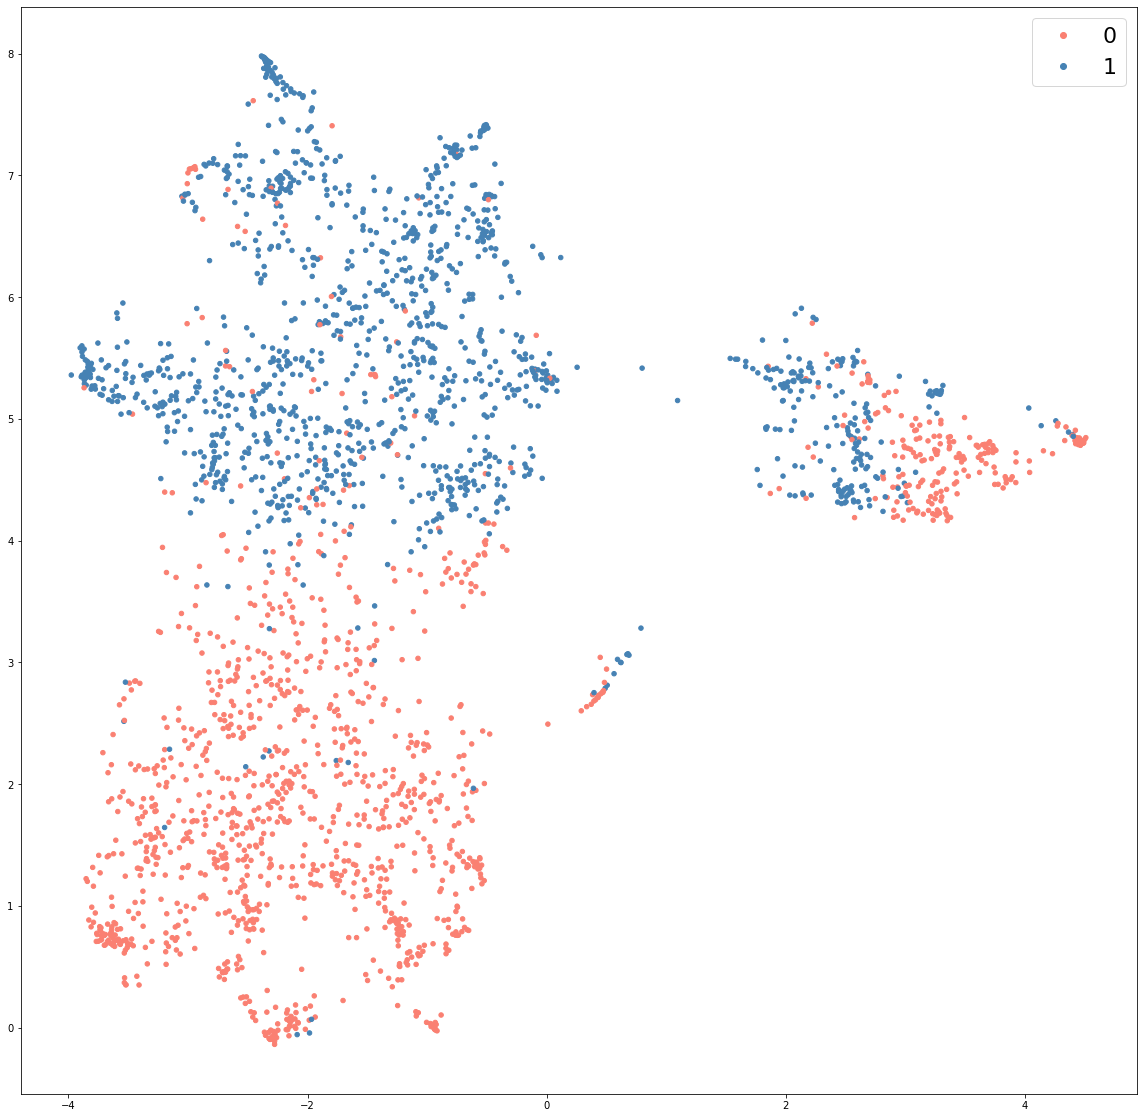

In [41]:
cmap = colors.ListedColormap(['salmon','steelblue'])
fig, ax = plt.subplots(figsize=(20,20))
scatter1 = ax.scatter(X_reduced_2[:][:, 0], X_reduced_2[:][:, 1], c=labels[:], s=20,cmap=cmap)
legend1 = ax.legend(*scatter1.legend_elements(),prop={'size': 22})